In [6]:
#!conda activate py38_estnltk1.7
# hpc serveris peaks sobima estnltk_collocations_py38
#!conda install --channel conda-forge pygraphviz
#!conda install -c conda-forge ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

# Skript näitejoonise tegemiseks

Lausepuu, kus on ära märgitud verb + verbi transaktsiooni liikmed.

Näiteks valisime lause id=42 (koondkorpus_sentences_test_5000_sg_thread).

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:storage.py:57: connecting to host: 'postgres.keeleressursid.ee', port: '5432', dbname: 'estonian-text-corpora', user: 'zummy'
INFO:storage.py:108: schema: 'estonian_text_corpora', temporary: False, role: 'estonian_text_corpora_read'


  0%|          | 0/1 [00:00<?, ?doc/s]

Lause tekst:  Text(text='Rezhissöör Curtis Hanson ( LA Confidential , Wonder Boys ) , tegi Eminemiga enne võtete algust kuus nädalat proove .')
0


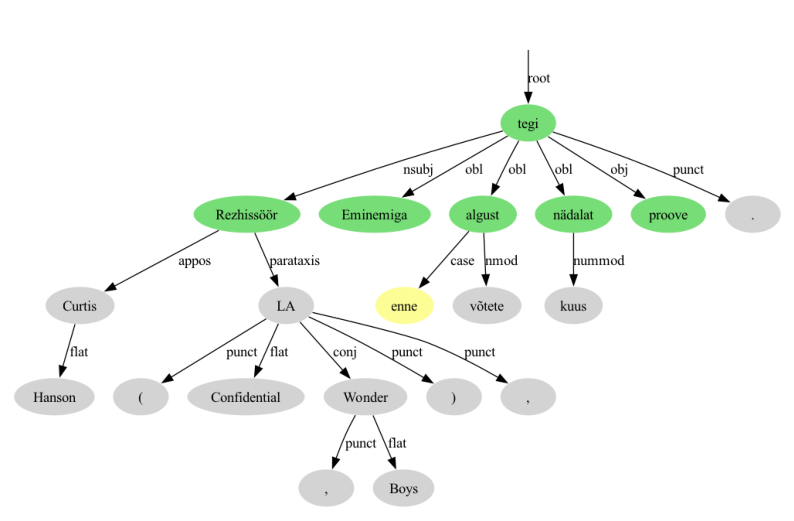

'transaktsioonid'

[{'sentence_id': 42,
  'loc': 12,
  'verb': 'tegema',
  'verb_compound': '',
  'feats': 'af,aux,impf,indic,ps,ps3,sg',
  'phrase_clear': 'Rezhissöör tegi Eminemiga enne enne algust nädalat proove',
  'phrase_full': 'Rezhissöör tegi Eminemiga enne algust nädalat proove .',
  'form': 'tegi',
  'deprel': 'root',
  'members': [{'loc': 1,
    'loc_rel': -1,
    'deprel': 'nsubj',
    'morf': 'morf',
    'form': 'Rezhissöör',
    'lemma': 'rezhissöör',
    'pos': 'S',
    'feats': 'com,nom,sg',
    'parent_loc': None},
   {'loc': 13,
    'loc_rel': 1,
    'deprel': 'obl',
    'morf': 'morf',
    'form': 'Eminemiga',
    'lemma': 'Eminemi',
    'pos': 'S',
    'feats': 'kom,prop,sg',
    'parent_loc': None},
   {'loc': 14,
    'loc_rel': 2,
    'deprel': 'case',
    'morf': 'morf',
    'form': 'enne',
    'lemma': 'enne',
    'pos': 'K',
    'feats': 'post',
    'parent_loc': 16},
   {'loc': 16,
    'loc_rel': 3,
    'deprel': 'obl',
    'morf': 'morf',
    'form': 'algust',
    'lemma': 'alg

collection_id: 42: 100%|##########| 1/1 [00:00<00:00,  2.18doc/s]

done.
CPU times: user 83.7 ms, sys: 20 ms, total: 104 ms
Wall time: 1.04 s


<Figure size 640x480 with 0 Axes>

In [7]:
%%time
%load_ext autoreload
%autoreload 2

# needed for draw_graph function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from estnltk.storage.postgres import LayerQuery

from datetime import datetime
# functions for creating database and collecting collocations
from collect_functions import *
from data_helpers.db_reader import DbReader
from data_helpers.syntax_graph import SyntaxGraph

class SyntaxGraphCustom(SyntaxGraph):
    # kustomiseeritud funktsioon lause puu joonistamiseks
    def draw_graph_example(
        self,
        display=False,
        filename=None,
        colors=[],
        highlight=[], # [{'color':'blue', 'nodes':[1,2]}, {'color':'yellow', 'nodes':[3,5]}]
    ):
        import pygraphviz as pgv

        # Create a default color for all nodes and a highlight color for selected nodes
        default_color = "#D3D3D3"  # lightgray
        
        node_colors = {}
        for h in highlight:
            for n in h['nodes']:
                node_colors[n] = h['color']
        # Create a new directed graph using pygraphviz
        G = pgv.AGraph(strict=True, directed=True)

        # Add nodes with 'label' attribute set to the 'lemma' from the original graph
        for node_id, data in self.nodes(data=True):
            label = data.get(
                "form", ""
            )  # Default to empty string if lemma is not present
            if not node_id:
                color = 'transparent'
            else:
                color = node_colors[node_id] if node_id in node_colors else default_color
                style = 'filled,setlinewidth(0)' if node_id in node_colors else "filled,setlinewidth(0)"
            
            if node_id:
                G.add_node(
                    node_id,
                    label=label,
                    shape="ellipse",
                    style=style,
                    fillcolor=color,
                )
            else:
                G.add_node(
                    node_id, label=label, shape="none", style=style, fillcolor=color
                )

        # Add edges with 'label' attribute set to the 'deprel' from the original graph
        for source, target, data in self.edges(data=True):
            label = data.get(
                "deprel", ""
            )
            G.add_edge(source, target, label=label)

        # Generate layout and draw the graph
        G.layout(prog="dot")

        # Set filename to default if not provided
        if not filename:
            filename = "graph.svg"

        # Draw graph to the specified file
        G.draw(filename)

        if display:
            # Display the graph image if we're in a Jupyter notebook environment
            img = mpimg.imread(filename)
            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            plt.axis("off")
            plt.show()
            plt.clf()
        return

    

collection_name = 'koondkorpus_sentences_test_5000_sg_thread'

SENTENCE_ID = 42

date_time = datetime.now().strftime("%Y%m%d-%H%M%S")
my_db_reader = DbReader(pgpass_file='~/.pgpass',\
                          schema='estonian_text_corpora',\
                          role='estonian_text_corpora_read',\
                          temporary=False,\
                          collection_name=collection_name)
my_db_reader.set_layers(['v172_stanza_syntax'])

collocations = []

# Värve natuke varuga, juhuks kui peaks tahtma joonistama puu, milles on mitu verbi transaktsiooni.
pastel_colors = [
    "#77DD77",  # Pastel Green
    "#FDFD96",  # Pastel Yellow
    "#A7C7E7",  # Pastel Blue
    "#FFB347",  # Pastel Orange
    "#FF6961",  # Pastel Red
    "#CDB4DB",  # Pastel Purple
    "#FFD1DC"   # Pastel Pink
]


for collection_id, text in my_db_reader.get_collections(shuffle=False, progressbar='ascii', col_ids=[SENTENCE_ID]):

    collocations, = extract_something(text=text, collection_id=collection_id, data=[])
    if not len(collocations): continue
    graph = SyntaxGraphCustom(text["v172_stanza_syntax"])
    print('Lause tekst: ', text)
    
    highlight = []
    for i, verb_transaction in enumerate(collocations):
        print(i)
        h = {}
        tr_head = verb_transaction['loc']
        tr_kids = [m['loc'] for m in verb_transaction['members'] if not m['parent_loc']]
        tr_grandkids = [m['loc'] for m in verb_transaction['members'] if m['parent_loc']]
        h['nodes'] = [tr_head] + tr_kids
        h['color'] = pastel_colors[0] # green 
        highlight.append(h)
        
        if tr_grandkids:
             highlight.append({'color':  pastel_colors[1], 'nodes':  tr_grandkids})  # yellow
        
    graph.draw_graph_example(display=1, highlight=highlight, filename='example_tree.png')
    display('transaktsioonid', collocations)

print('done.')